# Excluding Content (Headers/Footers)

Often, PDFs have repeating headers or footers on every page that you want to ignore when extracting the main content. `natural-pdf` allows you to define exclusion regions.

We'll use a different PDF for this example, which has a distinct header and footer section: `0500000US42007.pdf`.

In [1]:
#%pip install "natural-pdf[all]"

In [2]:
from natural_pdf import PDF

pdf_url = "https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/0500000US42007.pdf"

# Load the PDF
pdf = PDF(pdf_url)
page = pdf.pages[0]

# Let's see the bottom part of the text WITHOUT exclusions
# It likely contains page numbers or other footer info.
full_text_unfiltered = page.extract_text()

# Show the last 200 characters (likely containing footer text)
full_text_unfiltered[-200:]

' C THOMAS 2 2 0 0\nGRN LEILA HAZOU 2 1 1 0\nCST MARTY SELKER 2 2 0 0\nWrite-In Totals 0 0 0 0\nPrecinct Summary - 11/06/2024 12:22 AM Page 1 of 387\nReport generated with Electionware Copyright © 2007-2020'

## Approach 1: Excluding a Fixed Area

A simple way to exclude headers or footers is to define a fixed region based on page coordinates. Let's exclude the bottom 200 pixels of the page.

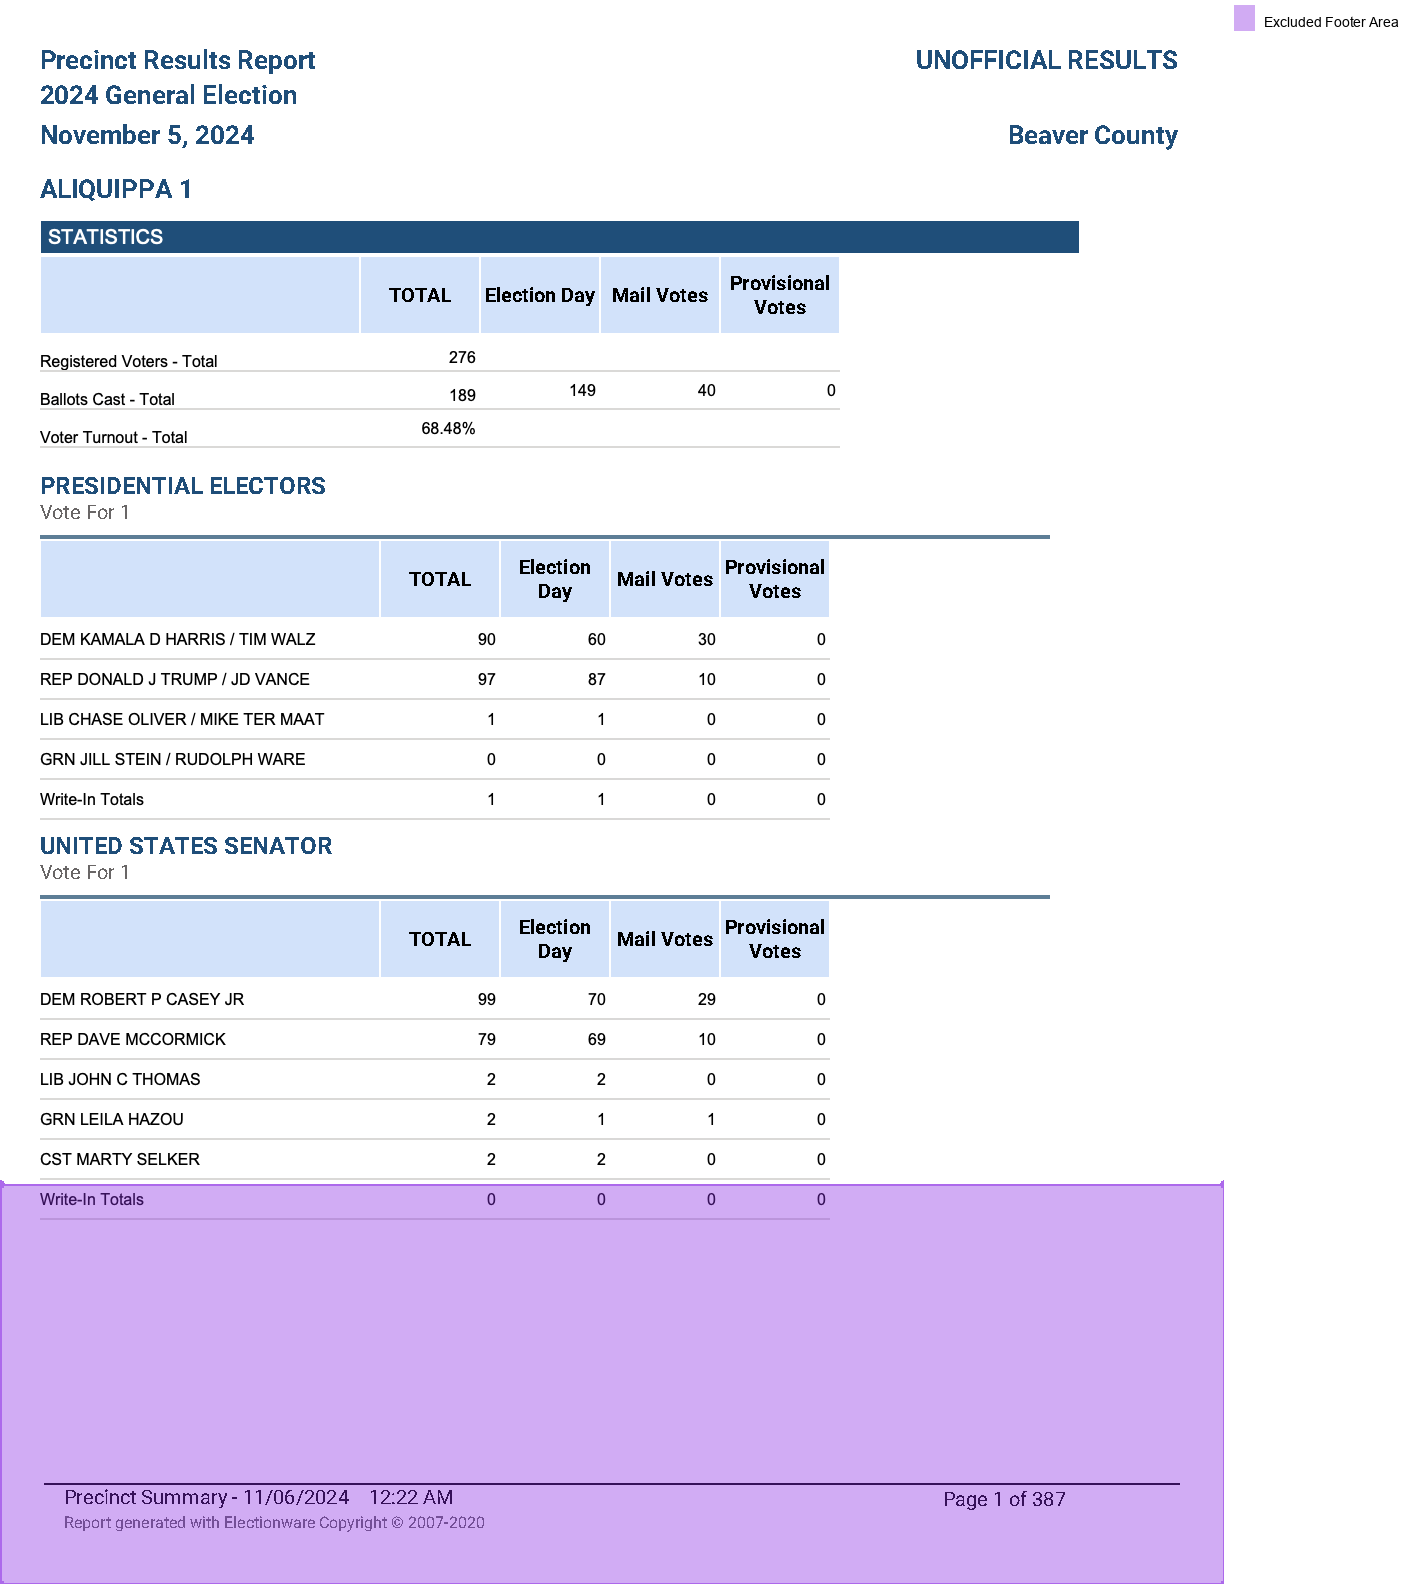

In [3]:
from natural_pdf import PDF

pdf_url = "https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/0500000US42007.pdf"
pdf = PDF(pdf_url)

# Define the exclusion region on every page using a lambda function
footer_height = 200
pdf.add_exclusion(
    lambda page: page.region(top=page.height - footer_height),
    label="Bottom 200pt Footer"
)

# Now extract text from the first page again, exclusions are active by default
page = pdf.pages[0]

# Visualize the excluded area
footer_region_viz = page.region(top=page.height - footer_height)
footer_region_viz.highlight(label="Excluded Footer Area")
page.to_image()

In [4]:
filtered_text = page.extract_text() # use_exclusions=True is default

# Show the last 200 chars with footer area excluded
filtered_text[-200:]

'TOR\nVote For 1\nElection Provisional\nTOTAL Mail Votes\nDay Votes\nDEM ROBERT P CASEY JR 99 70 29 0\nREP DAVE MCCORMICK 79 69 10 0\nLIB JOHN C THOMAS 2 2 0 0\nGRN LEILA HAZOU 2 1 1 0\nCST MARTY SELKER 2 2 0 0'

This method is simple but might cut off content if the footer height varies or content extends lower on some pages.

## Approach 2: Excluding Based on Elements

A more robust way is to find specific elements that reliably mark the start of the footer (or end of the header) and exclude everything below (or above) them. In `Examples.md`, the footer was defined as everything below the last horizontal line.

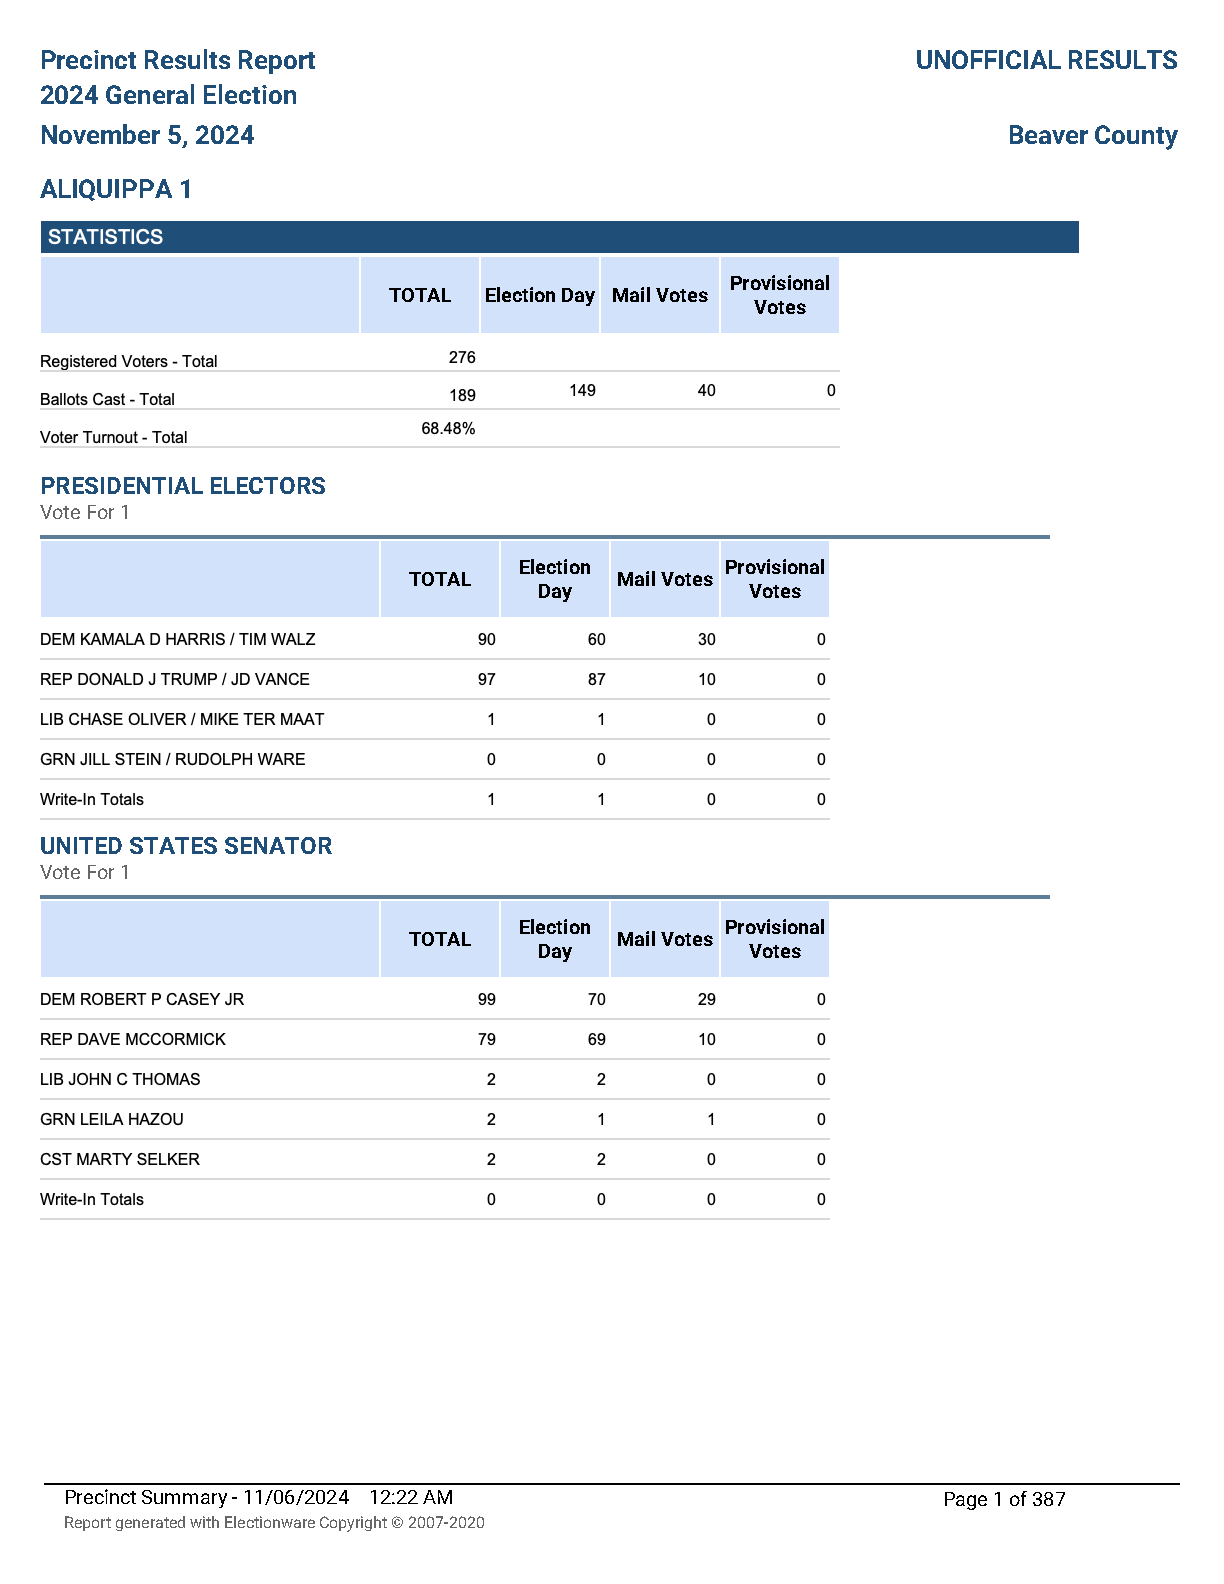

In [5]:
from natural_pdf import PDF

pdf_url = "https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/0500000US42007.pdf"
pdf = PDF(pdf_url)
page = pdf.pages[0] # Get page for finding elements

# Find the last horizontal line on the first page
# We'll use this logic to define our exclusion for all pages
last_line = page.find_all('line')[-1]

# Define the exclusion function using a lambda
# This finds the last line on *each* page and excludes below it
pdf.add_exclusion(
    lambda p: p.find_all('line')[-1].below(),
    label="Element-Based Footer"
)

# Extract text again, with the element-based exclusion active
filtered_text_element = page.extract_text()

# Show the last 200 chars with element-based footer exclusion
"Element-Based Excluded (last 200 chars): " + filtered_text_element[-200:]

# Visualize the element-based exclusion area
page.clear_highlights()
# Need to find the region again for visualization
footer_boundary = page.find_all('line')[-1]
footer_region_element = footer_boundary.below()
footer_region_element.show(label="Excluded Footer Area (Element)")
page.to_image()

This element-based approach is usually more reliable as it adapts to the content's position, but it depends on finding consistent boundary elements (like lines or specific text markers).

<div class="admonition note">
<p class="admonition-title">Applying Exclusions</p>

    *   `pdf.add_exclusion(func)` applies the exclusion function (which takes a page and returns a region) to *all* pages in the PDF.
    *   `page.add_exclusion(region)` adds an exclusion region only to that specific page.
    *   `extract_text(use_exclusions=False)` can be used to temporarily disable exclusions.
</div> 